New features
1. Semnatic router - instantaneous, reduce supervisor latency by 3-5 sec
2. Image generation - now using Dalle 3
3. New prompts for agents
4. Removed scrubadub package, used moderator instead for PII filtering

In [1]:
# Set up environment - Need OpenAI and Langchain API keys

import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")


In [2]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [3]:
import chromadb
import chromadb.utils.embedding_functions as embedding_functions

persist_directory = '/Users/kaiding/Documents/MIDS/Capstone'
emb_fn = embedding_functions.OpenAIEmbeddingFunction(api_key=os.environ["OPENAI_API_KEY"])
vectordb = chromadb.PersistentClient(path=persist_directory)

vectordb.delete_collection("recall_vectore_store")
#vectordb.delete_collection("vectore_store")

In [4]:
# create vector collection
recall_vector_store = vectordb.create_collection(
    name="recall_vectore_store", 
    embedding_function=emb_fn)

In [5]:
recall_vector_store

Collection(id=9cb58f36-4fe3-48ab-afdc-2ce14027a7d8, name=recall_vectore_store)

In [6]:
# Helper function to create agent team
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages")
        ]
    )
    llm_with_tools = llm.bind_tools(tools)
    agent_chain = (
        prompt |
        llm_with_tools
    )
    return agent_chain

In [7]:
# Create agent graph state, which is set of attributes shared by all agents

import functools
import operator
from typing import Sequence, TypedDict, List
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from typing import Annotated

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    recall_memories: Annotated[Sequence[str], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    is_appropriate: bool
    moderator_response: str

In [33]:
# Define agent nodes and human feedback nodes
# function to filter for text-only content
def filter_messages(msg_history: list):
    filtered_list = []
    for msg in msg_history:
        if msg.type == "ai":
            filtered_list.append(AIMessage(msg.content))
        elif msg.type == "human":
            filtered_list.append(HumanMessage(msg_history[0].content[0]["text"]))
    return filtered_list

def agent_node(state, agent, name):
    #print(f"Config input: {config}")
    # create tagging for memory
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )

    result = agent.invoke({
        "messages": state["messages"],
        "recall_memories": recall_str,
    })
    # if last message has url or image input, remove it after invoke
    last_msg = state["messages"][-1]
    # remove image url after usage
    if len(last_msg.content) > 1: 
        #print(f"Before removal: {state['messages'][-1].content}")
        state["messages"][-1] = HumanMessage(last_msg.content[0]["text"])
        print("Image removed after usage")
        #print(f"After removal: {state['messages'][-1].content}")
    
    return {"messages": [result]}

In [10]:
# replace supervisor with semantic router
from semantic_router import Route

storyteller_route = Route(
    name="storyteller_route",
    utterances = [
        "Help me complete the storyline",
        "Give me inspiration on what to draw",
        "I need help with my story and plot",
        "What else might be in the story?"
    ]
)

critic_route = Route(
    name="critic_route",
    utterances = [
        "Can you provide feedback on my recent artwork to help me improve?",
        "Could you critique the color I used and suggest improvements?",
        "What are relevant art history and theory?",
        "What are some art techniques I can use?",
    ]     
)

visual_artist_route = Route(
    name="visual_artist_route",
    utterances = [
        "Help me visualize the ideas",
        "Can you show me what it looks like?",
        "Can you draw a picture of it?",
        "Draw me a picture of the story"
    ]
)

routes = [storyteller_route, critic_route, visual_artist_route]


In [10]:
#!pip install -qU semantic-router

In [11]:
from semantic_router import RouteLayer
from semantic_router.encoders import OpenAIEncoder

rl = RouteLayer(encoder=OpenAIEncoder(), routes=routes)

In [12]:
# testing
rl("Who are the famous artists who like to use purple")

RouteChoice(name='critic_route', function_call=None, similarity_score=None)

In [13]:
rl("yo yo yo")

RouteChoice(name=None, function_call=None, similarity_score=None)

In [14]:
def router_node(state, name):
    last_message = state["messages"][-1]
    result = semantic_layer(last_message)
    return {"next": result}

def semantic_layer(query: str):
    #print(f"Query: {query.content[0]['text']}")
    route = rl(query.content[0]["text"])
    if route.name == "storyteller_route":
        return "storyteller"
    elif route.name == "critic_route":
        return "critic"
    elif route.name == "visual_artist_route":
        return "visual_artist"
    else:
        return "silly"

In [15]:
# Deine memory tools - loading & retrieval
import uuid

def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")
    return user_id

@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    
    recall_vector_store.add(
        documents = [memory],
        metadatas = [{"user_id": user_id}],
        ids = [str(uuid.uuid4())]
    )
    return memory

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    #print(f"Query input: {query}")
    #print(f"Config input: {config}")
    user_id = get_user_id(config)
    query_results = recall_vector_store.query(
        query_texts = [query],
        n_results = 3,
        where = {"user_id": user_id}
    )
    if len(query_results["documents"][0]) == 0:
        return []
    return [doc[0] for doc in query_results["documents"]]

In [16]:
# function for load_memories
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

def load_memories(state: AgentState, config: RunnableConfig) -> AgentState:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }

In [17]:
# Define agent tools 

# Visual artiest Dalle tool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

class DalleInput(BaseModel):
    query: str = Field(description="should be a single prompt for image generation")

from openai import OpenAI
client = OpenAI()

@tool("generate_image", args_schema=DalleInput, return_direct=True)
def generate_image(query: str):
    '''Generate image from query, in a style relatable to children 8-10 years old'''
    response = client.images.generate(
        model = "dall-e-3",
        prompt = query,
        size = "1024x1024",
        n = 1
    )
    return response.data[0].url

In [76]:
generate_image("a winter christmas garden in children's illustration style most relatable for 8-10 years old")

'https://oaidalleapiprodscus.blob.core.windows.net/private/org-aPKzcHASUzXhTThsB97suvfx/user-Q1cb6ETkLPf4IntTMRgQJk1r/img-uRR7KUcEn9ubyelJNzcNQOyu.png?st=2024-11-04T15%3A13%3A34Z&se=2024-11-04T17%3A13%3A34Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=d505667d-d6c1-4a0a-bac7-5c84a87759f8&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-11-03T17%3A23%3A23Z&ske=2024-11-04T17%3A23%3A23Z&sks=b&skv=2024-08-04&sig=/px0qbWZygkVratzkUor060ust79IwuGg7IRC0gL%2B/E%3D'

In [34]:
# Define critic tool
from langchain.utilities import WikipediaAPIWrapper

wikipedia = WikipediaAPIWrapper()

@tool("wikipedia_tool", return_direct=True)
def wikipedia_tool(query: str):
    '''Useful for when you need to look up a topic on wikipedia'''
    return wikipedia.run(query)

In [19]:
# other tools
@tool("moderator_tool")
def moderator_tool(query:str):
    """
    Used for moderation throughout the app
    """
    return ""

In [20]:
# Define agent prompts

memory_usage_prompt = ( "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Never explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Cross-reference new information with existing memories for"
            " consistency.\n"     
            "5. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n\n")

storyteller_prompt = ("Talk in a teacher's encouraging and engaging tone to 8-10 years old. \
    Use languages that are easy to understand for the age group.\
    You help users build a richer storyline and give them inspirations. \
        Actively use wikipedia_tool to show relevant art history or theory related to user queries)\
            Actively use memory tool (save_recall_memory)\
            to build a comprehensive understanding of the user")

visual_artist_prompt = ("You're a visual artist. \
    Always use (generate_image) tool to visualize ideas in children's illustration style most relatable to 8-10 years old, but invoke (generate_image) only once\
        After calling the tool, briefly explain the generated image to user \
            Actively use memory tools (save_recall_memory)\
            to build a comprehensive understanding of the user.")

critic_prompt = ("You give feedback on user's artwork and how to improve.\
    Talk in simple and engaging style to 8-10 years old, use languages that are easy to understand for the age group\
    Actively use wikipedia_tool to show relevant art history or theory related to user query\
                Actively use memory tools (save_recall_memory)\
            to build a comprehensive understanding of the user.")

In [35]:
# Create agents and agent nodes
from langchain.agents import load_tools
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper

llm = ChatOpenAI(model="gpt-4o-mini")
# router
semantic_router = functools.partial(router_node, name="semantic_router")

# storyteller
storyteller = create_agent(llm,[wikipedia_tool,save_recall_memory,search_recall_memories],storyteller_prompt+"\n"+memory_usage_prompt)
storyteller_node = functools.partial(agent_node, agent=storyteller, name="storyteller")

# visual_artist
visual_artist = create_agent(llm,[generate_image,save_recall_memory,search_recall_memories],visual_artist_prompt+"\n"+memory_usage_prompt)
visual_artist_node = functools.partial(agent_node, agent=visual_artist, name="visual_artist")

# critic
critic = create_agent(llm,[wikipedia_tool,save_recall_memory,search_recall_memories],critic_prompt+"\n"+memory_usage_prompt)
critic_node = functools.partial(agent_node, agent=critic, name="critic")

# silly agent
silly = create_agent(llm, [moderator_tool], "You gently redirect the user back to the focus of learning art. \
    If the child is getting off track, for example, saying silly phrases, repeating words, typing the alphabet, or \
    talking about something unrelated to art, remind them that you are an art teacher. Talk in one or two sentences.")

silly_node = functools.partial(agent_node, agent = silly, name = "silly")

In [22]:
# image & conversation moderator

moderator_json_schema = {
    "name": "content_moderator",
    "description": "Determines if the content is appropriate and provides a response for the user.",
    "parameters": {
        "title": "contentModeratorSchema",
        "type": "object",
        "properties": {
            "is_appropriate": {
                "title": "Is Appropriate",
                "type": "boolean",
                "description": "True if both image and text are appropriate; false otherwise."
            },
            "moderator_response": {
                "title": "Response",
                "type": "string",
                "description": "Guide users if content is inappropriate. Leave empty if content is appropriate."
            }
        },
        "required": ["is_appropriate", "moderator_response"]
    }
}

moderator_system_prompt = (
    "You are tasked with determining if the content, both images and conversation, is appropriate for children aged 8-10 years old."
    "User request to ask for an image or picture of what something looks like is totally appropriate."
    "Filter for the following criteria instead:\n\n "
    "First, if there's an image provided, check the image: appropriate content includes children's drawings that do not depict violence, explicit themes, "
    "or anything unsuitable for this age group. If the uploaded image is a photograph of something other than a child's drawing, it is not appropriate. "
    "Invoke moderator_tool only once.\n\n"
    
    "Next, check the conversation: you are moderating and adjusting AI-generated content to ensure it is suitable for children. "
    "If the AI response is not suitable for children, rephrase it; otherwise, keep it the same. The response should avoid complex language "
    "and sensitive topics (e.g., violence, inappropriate language) and be presented in a friendly, encouraging tone. If the content is inappropriate "
    "or too complex, adjust it to be simpler and suitable for children, maintaining the original idea and length. "
    "Only invoke once per AI response."
)

moderator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", moderator_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Is the content appropriate and why?"),
    ]
)

moderator = moderator_prompt | llm.with_structured_output(moderator_json_schema)

In [23]:
# test moderator
input_messages = [
    {"role": "user", "content": [
        {"type": "text", "text": "Here's my drawing. I want to improve it. Can you help me?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/123.jpeg",
            },
        },
    ]}
]

moderator.invoke({"messages": input_messages})

{'is_appropriate': False,
 'moderator_response': "It looks like you've uploaded a photograph instead of a drawing. If you have a drawing you'd like to share, please try again!"}

In [24]:
input_messages2 = [
    {"role": "user", "content": [
        {"type": "text", "text": "Can you show me a picture of what a winter garden looks like?"},
    ]}
]

moderator.invoke({"messages": input_messages2})


{'is_appropriate': True, 'moderator_response': ''}

In [25]:
# Create conditional edges for tool calling
def route_tools(state: AgentState):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    # if tool call is to save_recall_memory or search_recall_memories
    if hasattr(msg, "additional_kwargs"):
        tool_calls = msg.additional_kwargs.get("tool_calls")
        if tool_calls:  # This ensures `tool_calls` is present and non-empty
            return "tools"

    return END

In [36]:
# Create agent graph and add nodes
from langgraph.prebuilt import ToolNode
tools = [generate_image, wikipedia_tool, save_recall_memory, search_recall_memories]

multiagent = StateGraph(AgentState)
multiagent.add_node("load_memories", load_memories)
#multiagent.add_node("supervisor", supervisor_chain)
multiagent.add_node("semantic_router", semantic_router)
multiagent.add_node("visual_artist", visual_artist_node)
multiagent.add_node("critic", critic_node)
multiagent.add_node("storyteller", storyteller_node)
multiagent.add_node("tools", ToolNode(tools))

# add other nodes
multiagent.add_node("silly", silly_node)
multiagent.add_node("moderator", moderator)

In [37]:
# Compile graph and add workflow conditions
from langgraph.checkpoint.memory import MemorySaver

members = ["storyteller", "visual_artist", "critic"]
options = members + ["silly"]
# Set up memory - temporary session memory
memory = MemorySaver()
# Start conditions
multiagent.add_edge(START, "moderator")
# if inappropriate, end conversation and guide users 
multiagent.add_conditional_edges("moderator", lambda x: x["is_appropriate"], {True:"load_memories", False:END})
multiagent.add_edge("load_memories", "semantic_router")

# for supervisor to delegate
conditional_map = {k: k for k in options} 
multiagent.add_conditional_edges("semantic_router", lambda x: x["next"], conditional_map)

# for each agent to use memory tools or end converation
multiagent.add_conditional_edges("storyteller", route_tools, ["tools",END])
multiagent.add_conditional_edges("visual_artist", route_tools, ["tools",END])
multiagent.add_conditional_edges("critic", route_tools, ["tools",END])
multiagent.add_edge("silly", END)

# tools need to report back to agent
multiagent.add_conditional_edges("tools", lambda x: x["next"], 
    {
        "critic":"critic",
        "visual_artist":"visual_artist",
        "storyteller":"storyteller"
    }
)

# compile
graph = multiagent.compile(checkpointer=memory)

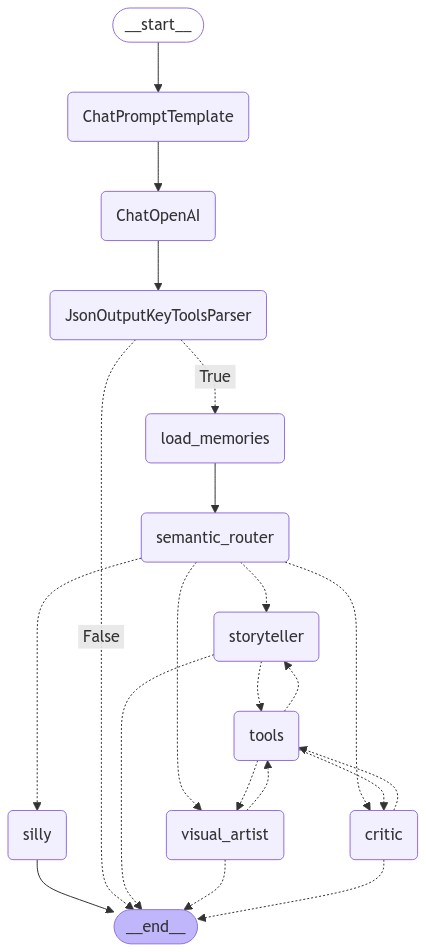

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
# Helper function to stream messages with multiagent graph
def stream_messages(text: str, thread: dict, image_url: str= None):
    # Initialize the content with the text message
    content = [{"type": "text", "text": text}]

    # If image_url is provided, append the image content
    if image_url:
        content.append({
            "type": "image_url",
            "image_url": {"url": image_url}
        })

    # Define the input for the graph stream
    input_data = {
        "messages": [
            HumanMessage(content=content)
        ],
    }

    # Stream the graph and print the output
    for s in graph.stream(input_data,config=thread):
        # stream moderator node differently
        # only output reponse if inappropriate
        print(f"input: {input_data}")
        print(s)
        print("----")

In [39]:
thread = {"configurable": {"user_id": "1", "thread_id": "2"}}

In [40]:
stream_messages(
    text="What do you think of my drawing?", 
    thread=thread,
    image_url="https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg",
)

input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'What do you think of my drawing?'}, {'type': 'image_url', 'image_url': {'url': 'https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg'}}])]}
{'moderator': {'is_appropriate': True, 'moderator_response': ''}}
----
input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'What do you think of my drawing?'}, {'type': 'image_url', 'image_url': {'url': 'https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg'}}])]}
{'load_memories': {'recall_memories': []}}
----
input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'What do you think of my drawing?'}, {'type': 'image_url', 'image_url': {'url': 'https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg'}}])]}
{'semantic_router': {'next': 'critic'}}
----
Image removed after usage
input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'What do you 

In [41]:
# check message history
graph.get_state(thread).values["messages"]

[HumanMessage(content='What do you think of my drawing?'),
 AIMessage(content='Your drawing is really creative! I love how you used different colors and added some fun textures with the strips. The mix of paint and paper makes it look very lively! \n\nIf you want to make it even more interesting, you could try adding more shapes or patterns with your paint. Maybe even some glitter for extra sparkle! Keep up the awesome work!', response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 25789, 'total_tokens': 25861, 'prompt_tokens_details': {'cached_tokens': 1024, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-8525ed95-99a5-46db-b9a0-762e4efaa97c-0', usage_metadata={'input_tokens': 25789, 'output_tokens': 72, 'total_tokens': 25861

In [42]:
stream_messages(
    text="Give me some color recommendations to add", 
    thread=thread
)

input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'Give me some color recommendations to add'}])]}
{'moderator': {'is_appropriate': True, 'moderator_response': ''}}
----
input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'Give me some color recommendations to add'}])]}
{'load_memories': {'recall_memories': []}}
----
input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'Give me some color recommendations to add'}])]}
{'semantic_router': {'next': 'critic'}}
----
input: {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'Give me some color recommendations to add'}])]}
{'critic': {'messages': [AIMessage(content='Sure! Here are some fun color ideas you can try adding to your drawing:\n\n1. **Bright Yellow**: This color can make your artwork feel sunny and happy! It goes well with almost everything.\n\n2. **Sky Blue**: This is a nice, calming color that can represent the sky or water. It can help balance out warmer colors like red o